# Is there a recency bias at oscars?

In [1]:
import pandas as pd
import numpy as np
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats 
%matplotlib inline

In [2]:
oscars = pd.read_csv('oscars_merged.csv')
oscars.head()

,film_id,film,year_film,year_ceremony,date_ceremony,oscars,nominations,audienceScore,tomatoMeter,rating,releaseDateTheaters,runtimeMinutes,genre,originalLanguage,boxOffice,days_to_ceremony,English
0,ben-hur_1959,Ben-Hur,1959,1960,1960-04-04,11,12,89.0,85.0,NaN,1959-11-18,203.0,History,English,NaN,138,Yes
1,titanic_1997,Titanic,1997,1998,1998-03-23,11,14,69.0,88.0,PG-13,1997-12-19,195.0,History,English,$658.8M,94,Yes
2,the_lord_of_the_rings:_the_return_of_the_king_...,The Lord of the Rings: The Return of the King,2003,2004,2004-02-29,11,11,86.0,93.0,PG-13,2003-12-17,200.0,Fantasy,English,$377.8M,74,Yes
3,west_side_story_1961,West Side Story,1961,1962,1962-09-04,10,11,84.0,92.0,NaN,1961-10-18,151.0,Musical,English,NaN,321,Yes
4,the_last_emperor_1987,The Last Emperor,1987,1988,1988-11-04,9,9,88.0,87.0,NaN,1987-11-18,162.0,Biography,English,$43.0M,352,Yes


In [3]:
oscars['releaseDateTheaters'] = pd.to_datetime(oscars['releaseDateTheaters'])
oscars['releaseMonth'] = oscars['releaseDateTheaters'].dt.month

In [4]:
#pandas profiling

#report = oscars.profile_report()
#report.to_file(output_file = "oscars_report.html")

# Initial data exploration

Does the genre matter?

In [5]:
genres = oscars.groupby(['genre']).agg({'nominations': 'sum','oscars': ['sum','mean']}).reset_index()
genres['oscars/nominations'] = genres[('oscars', 'sum')]/genres[('nominations', 'sum')]
genres.sort_values('oscars/nominations', ascending = False)

genre nominations oscars           oscars/nominations
                               sum    sum      mean                   
16                 War         233     67  0.943662           0.287554
8              History         447    128  1.142857           0.286353
7              Fantasy         152     43  0.826923           0.282895
5          Documentary         158     40  0.266667           0.253165
10              Horror          69     17  0.629630           0.246377
2            Biography         441    107  0.829457           0.242630
14             Romance         402     96  0.662069           0.238806
12             Musical         566    129  0.597222           0.227915
0               Action         166     36  0.467532           0.216867
15              Sci-fi         214     46  0.567901           0.214953
11       Kids & family         356     75  0.421348           0.210674
6                Drama        2092    417  0.592330           0.199331
1            Adventure         291     53  0.495327           0.182131
3               Comedy        1038    178  0.421801           0.171484
4                Crime         297     50  0.561798           0.168350
17             Western         157     26  0.382353           0.165605
9              Holiday          31      4  0.500000           0.129032
13  Mystery & thriller         288     35  0.275591           0.121528

Text(0.55, 0.05, 'Note: Barplots include only genres from which movies got at least 200 nominations')

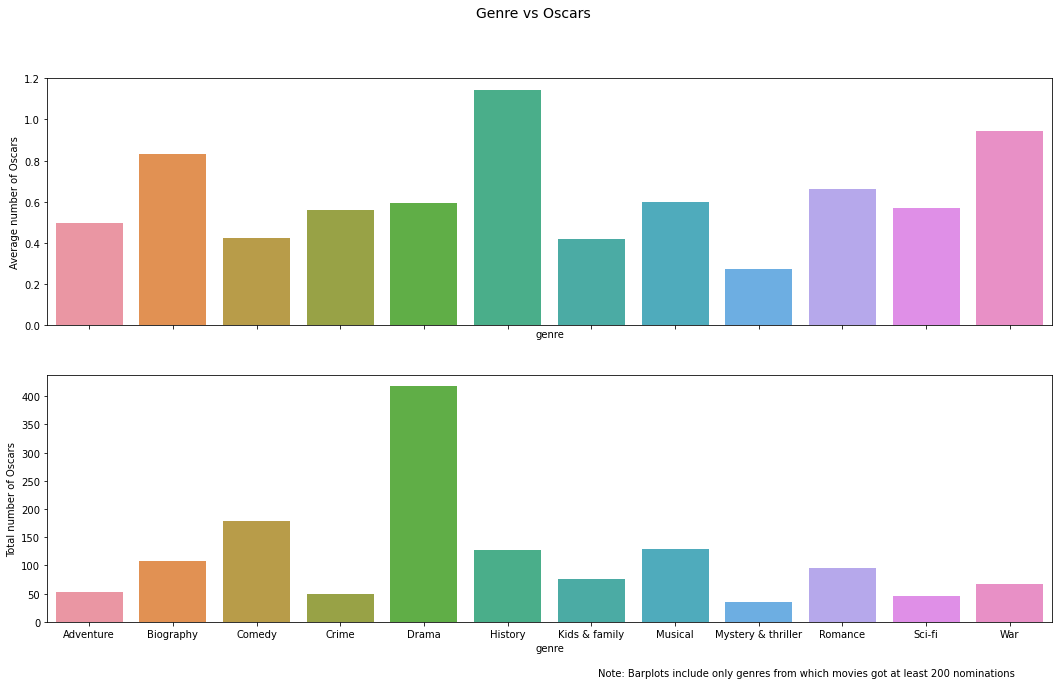

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(18,10), sharex=True)

fig.suptitle('Genre vs Oscars', fontsize = 14)

sn.barplot(x='genre', y=('oscars', 'mean'), data=genres[genres[('nominations','sum')] > 200], ax=ax1)
ax1.set_ylabel('Average number of Oscars')
sn.barplot(x='genre', y=('oscars', 'sum'), data=genres[genres[('nominations','sum')] > 200], ax=ax2)
ax2.set_ylabel('Total number of Oscars')

fig.text(0.55, 0.05, 'Note: Barplots include only genres from which movies got at least 200 nominations')

The most oscars was won by Drama movies, but that's because they've got by far the most nominations. History, War and Fantasy movies are the most successfull in terms of the average number of oscars won, while genres like Comedy, Family, Documentary, Thriller and Western are lagging behind. 

What about ratings (PG, PG-13, R)?

In [7]:
print(oscars['rating'].value_counts())

R        314
PG-13    271
PG       119
NC-17      1
Name: rating, dtype: int64


In [8]:
ratings = oscars.groupby(['rating']).agg({'nominations': 'sum','oscars': ['sum','mean']}).reset_index()
ratings['oscars/nominations'] = ratings[('oscars', 'sum')]/ratings[('nominations', 'sum')]
ratings.sort_values('oscars/nominations', ascending = False)

rating nominations oscars           oscars/nominations
                 sum    sum      mean                   
2  PG-13         798    185  0.682657           0.231830
1     PG         213     46  0.386555           0.215962
3      R        1027    220  0.700637           0.214216
0  NC-17           1      0  0.000000           0.000000

Movies with "PG" category are not very successfull at oscars, which is in line with previous observation that family movies also don't get a lot of awards. 

Text(0, 0.5, 'Total number of Oscars')

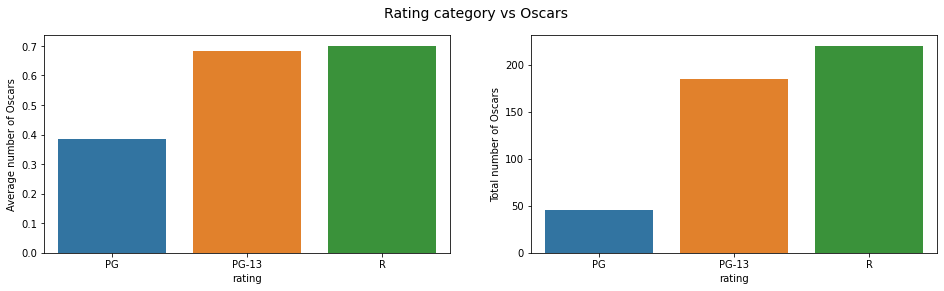

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,4), sharex=True)

fig.suptitle('Rating category vs Oscars', fontsize=14)

sn.barplot(x='rating', y=('oscars', 'mean'), data=ratings[ratings['rating'] != 'NC-17'], ax=ax1)
ax1.set_ylabel('Average number of Oscars')
sn.barplot(x='rating', y=('oscars', 'sum'), data=ratings[ratings['rating'] != 'NC-17'], ax=ax2)
ax2.set_ylabel('Total number of Oscars')

What's the relationship with other continuous variables (audienceScore, tomatoMeter, runtime, boxOffice)?

<AxesSubplot:>

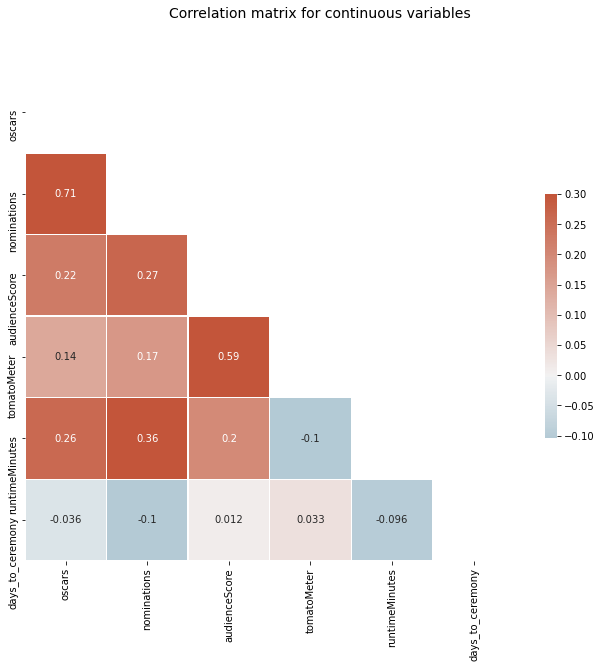

In [10]:
corr = oscars[['oscars', 'nominations', 'audienceScore', 'tomatoMeter', 'runtimeMinutes', 'boxOffice', 'days_to_ceremony']].corr()

# 'mask'
mask = np.triu(np.ones_like(corr, dtype=bool))

# heatmap
fig, ax = plt.subplots(figsize=(11, 9))

fig.suptitle('Correlation matrix for continuous variables', fontsize=14)

cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

If there is a recency bias at oscars we would expect that the correlation between Oscars and days_to_ceremony will be negative. It's indeed the case, however the coefficient is very low (-0.036). Number of Oscars won seems to possitevely correlate with audience ratings, critics ratings and movie length, however the coeffs are not very high. Will results change significantly if we will use only data for movies that won at least 1 Oscar?

<AxesSubplot:>

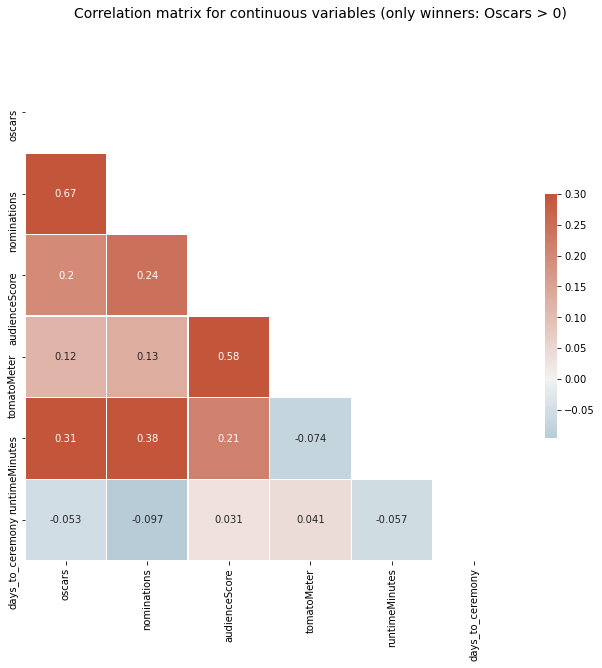

In [11]:
winners = oscars[oscars['oscars'] > 0]
corr = winners[['oscars', 'nominations', 'audienceScore', 'tomatoMeter', 'runtimeMinutes', 'boxOffice', 'days_to_ceremony']].corr()

# 'mask'
mask = np.triu(np.ones_like(corr, dtype=bool))

# heatmap
fig, ax = plt.subplots(figsize=(11, 9))

fig.suptitle('Correlation matrix for continuous variables (only winners: Oscars > 0)', fontsize=14)

cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It doesn't seem to make a huge difference. 

Maybe just better movies are released closer to ceremony date?

<AxesSubplot:xlabel='days_to_ceremony', ylabel='tomatoMeter'>

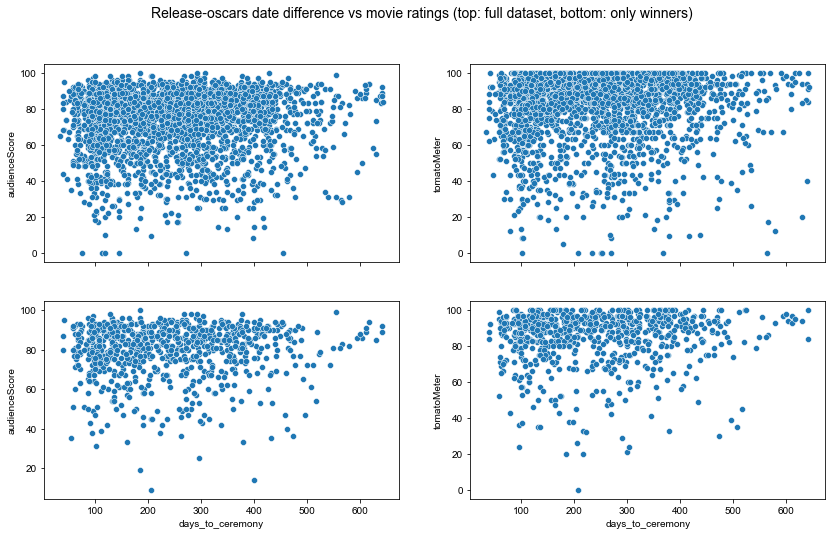

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(14,8), sharex=True)

fig.suptitle('Release-oscars date difference vs movie ratings (top: full dataset, bottom: only winners)', fontsize = 14)

sn.set()
sn.scatterplot(x='days_to_ceremony', y='audienceScore', data=oscars, ax=ax1)

sn.set()
sn.scatterplot(x='days_to_ceremony', y='tomatoMeter', data=oscars, ax=ax2)

sn.set()
sn.scatterplot(x='days_to_ceremony', y='audienceScore', data=winners, ax=ax3)

sn.set()
sn.scatterplot(x='days_to_ceremony', y='tomatoMeter', data=winners, ax=ax4)

In [13]:
months = oscars.groupby('releaseMonth').agg({'film':'count', 'oscars': 'mean'})
months.columns = ['number of released movies', 'avg number of oscars']
months

,number of released movies,avg number of oscars
releaseMonth,,
1,92,0.597826
2,96,0.500000
3,160,0.550000
4,140,0.292857
5,181,0.491713
6,249,0.453815
7,205,0.541463
8,202,0.519802
9,239,0.414226


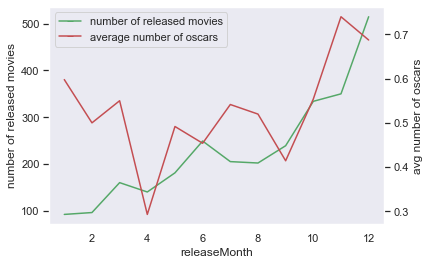

In [42]:
from matplotlib.lines import Line2D

sn.set_style('dark')
g = sn.lineplot(data=months['number of released movies'], color="g")
ax2 = plt.twinx()
sn.lineplot(data=months['avg number of oscars'], color="r", ax=ax2)
g.legend(handles=[Line2D([], [], marker='_', color="g", label='number of released movies'), Line2D([], [], marker='_', color="r", label='average number of oscars')])

Among the movies that were nominated most of them is released at the end of the year (probably because of the winter holidays). This movies have also the highest avg number of oscars. What's more movies released in January also score well in terms of avg oscars. Recency bias?

# Statistical Model

Considering that the dependend variable (number of oscars won) is count variable and there a lot of zeros, it may be right to use zero-inflated Poisson model. However this model assumes that mean of the dependent variable is equal to its variance, which in this case is not true. So instead, we may use Zero Inflated Negative Binomial model, which doesn't come with that assumption. 

In [15]:
import statsmodels.api as sm

mean:  0.5598986608758596
variance:  1.5187678391112378


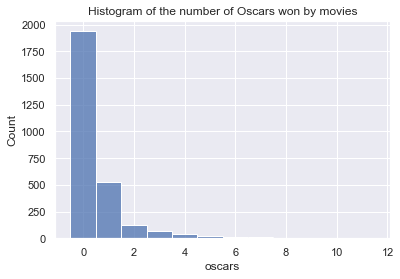

In [16]:
sn.set_style("darkgrid")
sn.histplot(oscars['oscars'], discrete = True)
plt.title('Histogram of the number of Oscars won by movies')

print('mean: ', oscars['oscars'].mean())
print('variance: ', oscars['oscars'].var())

In [17]:
oscars_withoutNA = oscars[oscars['rating'] != 'NC-17'][['oscars','days_to_ceremony', 'audienceScore', 'tomatoMeter', 'runtimeMinutes', 'rating']].dropna()
endo = oscars_withoutNA['oscars']

oscars_withoutNA = pd.get_dummies(data = oscars_withoutNA)
exog_var = oscars_withoutNA.drop(['oscars', 'rating_PG'], axis = 1)
#exog_var = oscars_withoutNA[['days_to_ceremony', 'audienceScore', 'tomatoMeter', 'runtimeMinutes']]  #'rating', 'genre']]

model_ZINB = sm.ZeroInflatedNegativeBinomialP(endog = endo, exog = exog_var, exog_infl = exog_var).fit()
print(model_ZINB.summary())

         Current function value: 1.055571
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                            oscars   No. Observations:                  695
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      689
Method:                                      MLE   Df Model:                            5
Date:                           Sat, 04 May 2024   Pseudo R-squ.:                 0.02130
Time:                                   19:46:44   Log-Likelihood:                -733.62
converged:                                 False   LL-Null:                       -749.59
Covariance Type:                       nonrobust   LLR p-value:                 6.119e-06
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

C:\Users\kszaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kszaf\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
C:\Users\kszaf\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


The model suggests that the recency bias is not a thing at Oscars (day_to_ceremony variable is not significant). What's interesting, audienceScore is negatively associated with Oscars won, while tomatoMeter (Critics score) is possitively associated with it. 

# Analysis only for movies that were nominated in the Best Picture category

Previous analysis suggests that there is no recency bias if we consider number of Oscars won be each movie, but maybe it will be different for the movies in the Best Picture category, which is the most important one. 

In [44]:
best = pd.read_csv('best_picture.csv')
best.head()

,year_film,year_ceremony,film,winner,film_id,audienceScore,tomatoMeter,runtimeMinutes,genre,boxOffice,days_to_ceremony,English,releaseMonth
0,1928,1929,The Patriot,0,the_patriot_1928,55.0,100.0,108.0,History,NaN,272,Yes,8
1,1929,1930,Disraeli,0,disraeli_1929,42.0,83.0,89.0,Biography,NaN,123,Yes,11
2,1929,1930,The Love Parade,0,the_love_parade_1929,77.0,100.0,107.0,Musical,NaN,105,Yes,11
3,1931,1932,Arrowsmith,0,arrowsmith_1931,42.0,89.0,108.0,Drama,NaN,328,Yes,12
4,1931,1932,Bad Girl,0,bad_girl_1931,40.0,NaN,90.0,Drama,NaN,463,Yes,8


Let's make similar analysis

In [45]:
genres = best.groupby(['genre']).agg({'winner': ['count', 'sum','mean']}).reset_index()
genres.sort_values(('winner', 'mean'), ascending = False)

genre winner              
                        count sum      mean
15                 War     17   5  0.294118
11             Musical     27   7  0.259259
7              History     39  10  0.256410
6              Fantasy      9   2  0.222222
2            Biography     27   5  0.185185
13             Romance     34   6  0.176471
4                Crime     24   4  0.166667
3               Comedy     75  12  0.160000
5                Drama    171  26  0.152047
12  Mystery & thriller     16   2  0.125000
16             Western      9   1  0.111111
10       Kids & family     11   1  0.090909
1            Adventure     19   1  0.052632
14              Sci-fi      7   0  0.000000
0               Action      5   0  0.000000
9               Horror      2   0  0.000000
8              Holiday      3   0  0.000000

Again, the most OScars in the best picture category was won by Dramas movies but that's only because they've got a lot of nominations. The best oscars/nominations ratio (mean) have War movies, Musicals and History movies. 

Does non-english movies stand a chance in the best picture category?

In [46]:
best['English'] = best['English'].replace({'Yes': 'English', 'No': 'Other'})

english = best.groupby('English').agg({'winner': ['count', 'sum']})
english.sort_values(('winner', 'sum'), ascending = False)

winner    
         count sum
English           
English    482  80
Other       13   2

Well, if they get nomination..

Now, let's check differences in averages of numerical variables for movies that won and the rest. 

In [47]:
#boxOffice variable has inconvenient format ($xxx.xK), lets change it

def convert(x):
    if x[-1] == 'K': return x[1:-1] + '00'
    elif x[-1] == 'M': return x[1:-1] + '00000'
    else: return x


best['boxOffice'] = best['boxOffice'].str.replace('.','').astype(str).apply(convert).sort_values().head(50)
best['boxOffice'] = best['boxOffice'].astype(float)

<ipython-input-47-41bf91d531f8>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  best['boxOffice'] = best['boxOffice'].str.replace('.','').astype(str).apply(convert).sort_values().head(50)


In [48]:
best['winner'] = best['winner'].astype(object)
best['boxOffice'] = best['boxOffice'].astype('Int32')
winner = best.groupby('winner').agg({'audienceScore': 'mean', 'tomatoMeter': 'mean', 'runtimeMinutes': 'mean', 'boxOffice': 'mean', 'days_to_ceremony': 'mean'})
winner.index = ['Nominated', 'Winners']
winner = winner.reset_index()
winner

,index,audienceScore,tomatoMeter,runtimeMinutes,boxOffice,days_to_ceremony
0,Nominated,81.165854,87.639903,124.334951,92314294.736842,230.794189
1,Winners,85.666667,89.493827,138.666667,100734933.333333,224.073171


Every average is higher for winners, apart from days_to_ceremony.. recency bias?

<AxesSubplot:xlabel='index', ylabel='boxOffice'>

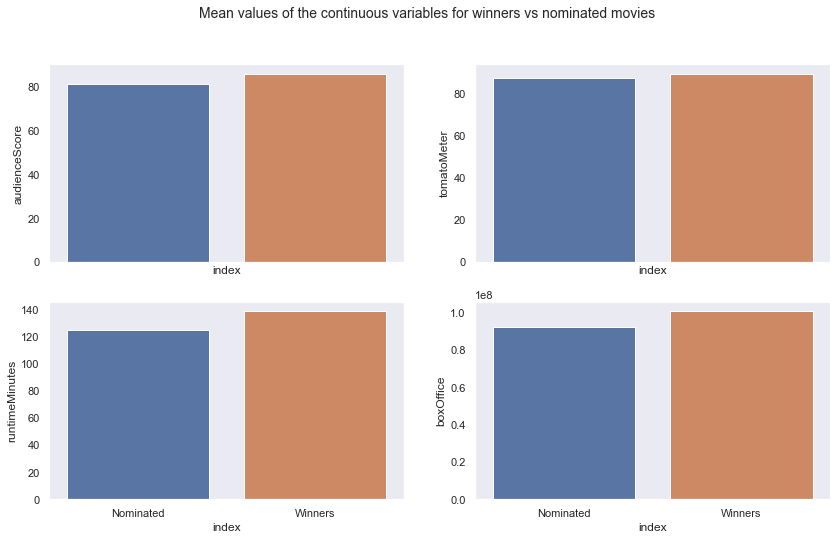

In [49]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(14,8), sharex=True)

fig.suptitle('Mean values of the continuous variables for winners vs nominated movies', fontsize = 14)

sn.barplot(x = 'index', y = 'audienceScore', data = winner, ax = ax1)
sn.barplot(x = 'index', y = 'tomatoMeter', data = winner, ax = ax2)
sn.barplot(x = 'index', y = 'runtimeMinutes', data = winner, ax = ax3)
sn.barplot(x = 'index', y = 'boxOffice', data = winner, ax = ax4)

The difference between means of the date_to_ceremony variable is not big, but maybe we should take a look at difference in full distributions. 

<AxesSubplot:xlabel='winner', ylabel='days_to_ceremony'>

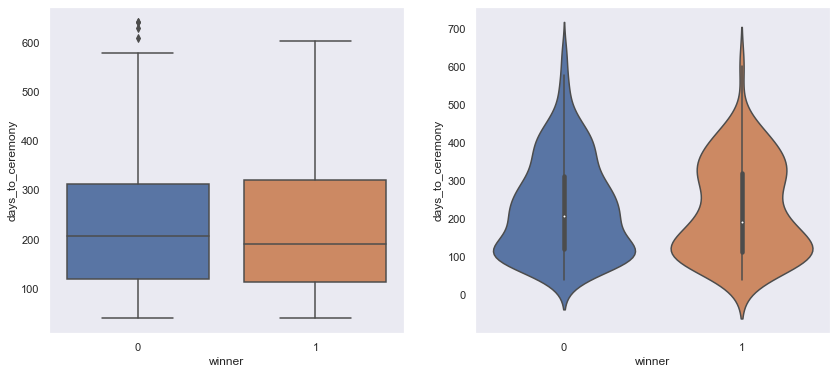

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (14,6), sharex=True)

sn.boxplot(x='winner', y='days_to_ceremony', data = best, ax=ax1)
sn.violinplot(x='winner', y='days_to_ceremony', data = best, ax=ax2)

Text(0.5, 1.05, 'Distribution of release month for winners vs nominated movies')

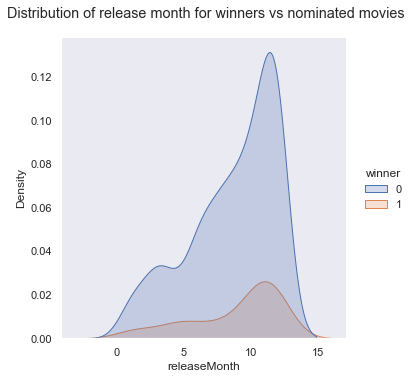

In [74]:
sn.displot(data = best, x = 'releaseMonth', hue = 'winner', kind = 'kde', fill = True)
plt.suptitle('Distribution of release month for winners vs nominated movies', y = 1.05)

As for choosing statistical model it seems appriopriate to use Logit, considering that dependent variable is binary. 

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
best.head(3)

,year_film,year_ceremony,film,winner,film_id,audienceScore,tomatoMeter,runtimeMinutes,genre,boxOffice,days_to_ceremony,English
0,1928,1929,The Patriot,0,the_patriot_1928,55.0,100.0,108.0,History,<NA>,272,English
1,1929,1930,Disraeli,0,disraeli_1929,42.0,83.0,89.0,Biography,<NA>,123,English
2,1929,1930,The Love Parade,0,the_love_parade_1929,77.0,100.0,107.0,Musical,<NA>,105,English


In [27]:
best_withoutNA = best[['winner', 'audienceScore', 'tomatoMeter', 'runtimeMinutes', 'genre','days_to_ceremony', 'English']].dropna()
best_withoutNA['winner'] = best_withoutNA['winner'].astype(int)
endo = best_withoutNA['winner']

best_withoutNA = pd.get_dummies(data = best_withoutNA)
exog = best_withoutNA.drop(['winner', 'genre_Drama', 'English_Other'], axis=1)

In [28]:
model_logit = sm.Logit(endo, exog)
results = model_logit.fit()
print(results.summary())

         Current function value: 0.434574
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                  490
Model:                          Logit   Df Residuals:                      469
Method:                           MLE   Df Model:                           20
Date:                Sat, 04 May 2024   Pseudo R-squ.:                 0.03076
Time:                        19:46:45   Log-Likelihood:                -212.94
converged:                      False   LL-Null:                       -219.70
Covariance Type:            nonrobust   LLR p-value:                    0.8542
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
audienceScore                0.0076      0.012      0.629      0.529      -0.016       0.031
tomatoMeter            

C:\Users\kszaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


It seems that our model is pretty bad at explaining dependent variable (most of variables are insignificant). Maybe oversampling would help.

In [29]:
from imblearn.over_sampling import SMOTE 

In [30]:
smote = SMOTE(random_state=42)
exog_sm, endo_sm,  = smote.fit_resample(exog, endo)

In [31]:
print(endo.value_counts())
print(endo_sm.value_counts())

0    409
1     81
Name: winner, dtype: int64
0    409
1    409
Name: winner, dtype: int64


In [32]:
model_logit_sm = sm.Logit(endo_sm, exog_sm)
results_sm = model_logit_sm.fit()
print(results_sm.summary())

         Current function value: 0.527675
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                  818
Model:                          Logit   Df Residuals:                      797
Method:                           MLE   Df Model:                           20
Date:                Sat, 04 May 2024   Pseudo R-squ.:                  0.2387
Time:                        19:46:45   Log-Likelihood:                -431.64
converged:                      False   LL-Null:                       -566.99
Covariance Type:            nonrobust   LLR p-value:                 7.390e-46
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
audienceScore                0.0286      0.010      2.939      0.003       0.010       0.048
tomatoMeter            

C:\Users\kszaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Oversampling worked, the model is significantly better. However our variable of interest (days_to_ceremony) is still insignificant, once again suggesting that there is no recency bias at oscars.